## Final Project Submission

Please fill out:
* Student name: Mac Lambert
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL:


# High Level Outline

The first step in building this model is to inspect and clean the dataset. We're looking for missing values, unexpected characters and anything that might throw our predictions off.

After cleaning, we'll explore what we have with some introductory data analysis questions. Knowing that this is a dataset of housing sale prices, our questions will be centered around which factors impact the price and how they do that.

Next, we'll dive into building a model to predict the sales price. We'll attempt to use all available data, but columns could be removed for various reasons: a p-value over .05, having no impact on the price, being highly covariant on another variable, etc. If needed, we'll also be transforming values and standardizing where appropriate.
Our R-squared value is the measure of success here; we're looking for something between 70 and 90%. 

After our model is complete, we can use the intercept and coeffecients to summarize the impact each variable has on the final selling price prediction.

# Your code here - remember to use markdown cells for comments as well!

# 1. Importing and Inspecting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('kc_house_data.csv')

In [2]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


* Okay, we have 21 columns and some obvious missing values in waterfront, yr_renovated
* Let's get a high level view of the dataset and any clean up needed

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Columns that need to be investigated: waterfront, view, yr_renovated
* all of these are missing values - some more than others!

In [4]:
print(df.waterfront.value_counts())

0.0    19075
1.0      146
Name: waterfront, dtype: int64


* This is a really low number of waterfront homes!
* I'm going to assume that houses with a waterfront would make sure to report it
* Missing values will become 0/false
* It's also okay to drop this column entirely, given the low number of positive values
* In this instance, the assumption above seems just as safe

In [5]:
# change missing waterfront values to 0
df.waterfront = df.waterfront.fillna(value=0)

In [6]:
print(np.mean(df.yr_renovated))
print(np.median(df.yr_renovated))
print(df.yr_renovated.value_counts())

83.6367783722895
nan
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Nam

//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


* Interesting - 17,011 houses have "0.0" for the year renovated - this is obviously not a year!
* So many have missing values that the median is nan!
* I'm going to assume that 0 for year renovated means it wasn't renovated
* Just like waterfront values, missing year renovated will become 0

In [7]:
# change yr_renovated missing value to 0
df.yr_renovated = df.yr_renovated.fillna(value=0)

In [8]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
480.0       103
450.0       103
530.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
1100.0       78
670.0        78
780.0        76
550.0        76
650.0        75
240.0        74
380.0        73
680.0        73
850.0        72
          ...  
274.0         1
2310.0        1
1548.0        1
506.0         1
2610.0        1
1798.0        1
2490.0        1
176.0         1
1024.0        1
556.0         1
1960.0        1
417.0         1
2720.0        1
1990.0        1
1852.0        1
1913.0        1
1930.0        1
225.0         1
2050.0        1
2500.0        1
374.0         1
2390.0        1
415.0         1
2180.0        1
915.0         1
1816.0        1
508.0         1
3260.0        1
1920.0        1
4820.0        1
Name: sqft_basement, Len

* Whoops - sqft_basement includes ? for 454 instances
* Let's drop these rows - 454 is a low number, compared to the overall dataset just 2%

* We should probably cycle through value_counts() for all columns
* Just because a value is present doesn't mean it's expected - like ? above

* Same idea here - we can assume that a missing view value is 0
* That wouldn't be true if this referred to "quality" of the view of the house
* Instead it's "has been viewed" in the description

In [9]:
# change view missing values to 0
df.view = df.view.fillna(value=0)
# drop rows with sqft_basement = ?
df = df[df.sqft_basement!="?"]

In [10]:
df.sqft_basement.value_counts()

0.0       12826
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
530.0       103
450.0       103
480.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
670.0        78
1100.0       78
780.0        76
550.0        76
650.0        75
240.0        74
380.0        73
680.0        73
850.0        72
360.0        72
          ...  
274.0         1
2310.0        1
1548.0        1
506.0         1
2610.0        1
1798.0        1
2490.0        1
176.0         1
1024.0        1
556.0         1
1960.0        1
417.0         1
2720.0        1
1990.0        1
1852.0        1
1913.0        1
1930.0        1
225.0         1
2050.0        1
2500.0        1
374.0         1
2390.0        1
415.0         1
2180.0        1
915.0         1
1816.0        1
508.0         1
3260.0        1
1920.0        1
4820.0        1
Name: sqft_basement, Len

* Next, let's look into types of data
* sqft_basement is stored as object
* These shouldn't be strings - they're (theoretically) numerical
* Let's change to float

In [11]:
# change sqft_basement to float
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
id               21143 non-null int64
date             21143 non-null object
price            21143 non-null float64
bedrooms         21143 non-null int64
bathrooms        21143 non-null float64
sqft_living      21143 non-null int64
sqft_lot         21143 non-null int64
floors           21143 non-null float64
waterfront       21143 non-null float64
view             21143 non-null float64
condition        21143 non-null int64
grade            21143 non-null int64
sqft_above       21143 non-null int64
sqft_basement    21143 non-null float64
yr_built         21143 non-null int64
yr_renovated     21143 non-null float64
zipcode          21143 non-null int64
lat              21143 non-null float64
long             21143 non-null float64
sqft_living15    21143 non-null int64
sqft_lot15       21143 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


Looks much better!

# 2. Exploratory Data Analysis

* does grade have any impact on selling price?
* what's the relationship between year renovated and sales price?
* most common house size sales
* are sales more or less common in certain areas of the county?

Text(0.5, 1.0, 'Sales Price by Grade')

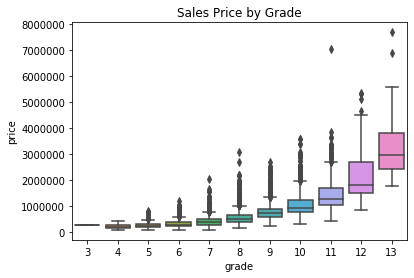

In [13]:
# Let's look at grade vs. price
ax = sns.boxplot(x='grade', y='price', data=df)
plt.title('Sales Price by Grade')
# Yes, definitely
# Especially 10 and above

(1930, 2020)

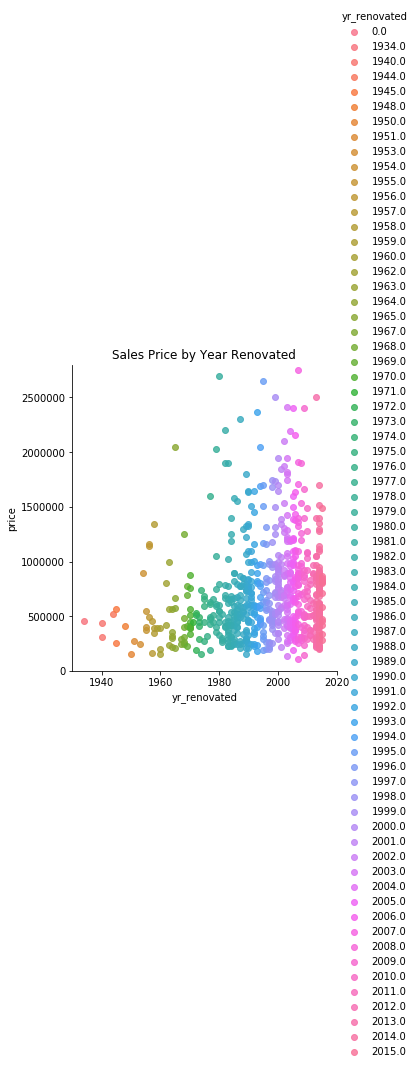

In [14]:
renovation = df[['yr_renovated', 'price']]
renovation.loc[(renovation['yr_renovated']!=0.0)]
display(sns.lmplot(x='yr_renovated', y='price', data=renovation,
           fit_reg=False,
           hue='yr_renovated')) 
plt.title('Sales Price by Year Renovated')
plt.ylim(0, 2800000)
plt.xlim(1930, 2020)
# year renovated certainly has an impact on sales price
# the outliers here are interesting - a renovation pre-1940 suggests a quite old house
# the number of very expensive sales (over 1.5 million) increases as we get into the 2000s

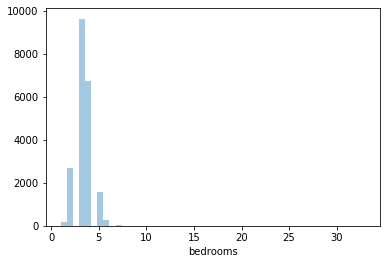

In [15]:
# Now, most common house size sales. Let's use number of bedrooms
ax = sns.distplot(df['bedrooms'], kde=False)
# according to the chart below, we have an outlier

In [16]:
df.bedrooms.value_counts()

3     9639
4     6740
2     2691
5     1560
6      262
1      191
7       36
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [ ]:
# WOW, that's wild - one house has 33 bedrooms
# It's interesting, but it's not helpful for seeing the histogram above
# Let's limit the x axis

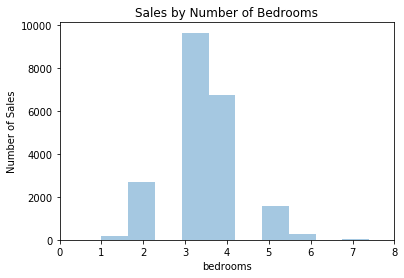

In [17]:
ax = sns.distplot(df['bedrooms'], kde=False)
plt.xlim(0,8)
plt.ylabel('Number of Sales')
plt.title('Sales by Number of Bedrooms')
plt.show()
# based on this plot, the majority of sales were for 3 or 4 bedrooms

In [18]:
# Lastly, let's look at average selling price by zip code
zip_vis = df.groupby(['zipcode'])['price'].mean().astype(int)
print(zip_vis)

zipcode
98001     281796
98002     234512
98003     294996
98004    1357422
98005     810291
98006     857619
98007     618653
98008     647429
98010     421444
98011     491044
98014     457307
98019     425467
98022     317079
98023     284697
98024     572654
98027     621071
98028     461384
98029     611542
98030     294332
98031     300216
98032     251594
98033     800049
98034     523314
98038     366561
98039    2135612
98040    1197903
98042     311699
98045     440104
98052     644415
98053     676416
          ...   
98092     335299
98102     903701
98103     586179
98105     866581
98106     319821
98107     577846
98108     356585
98109     876985
98112    1100568
98115     620108
98116     621184
98117     575256
98118     417834
98119     861480
98122     637139
98125     468364
98126     423315
98133     386653
98136     547915
98144     594059
98146     358809
98148     284815
98155     424566
98166     462076
98168     241457
98177     673722
98178     311145
98188 

In [19]:
# Okay, that doesn't tell us much. 
# Let's pull in the price with lat and long and see if we can map it

import folium
from folium import plugins
from folium.plugins import HeatMap

df_map = df[['price', 'lat', 'long']]

map_kc = folium.Map(location=[47.5480, -121.9836],
                    tiles = "Stamen Toner",
                    zoom_start = 9.5)

df_map['lat'] = df_map['lat'].astype(float)
df_map['long'] = df_map['long'].astype(float)
df_map['price'] = df_map['price'].astype(float)

heat_data = [[row['lat'],row['long']] for index, row in df_map.iterrows()]
HeatMap(heat_data).add_to(map_kc)

map_kc
# nothing unexpected here - sales map seems to follow population
# geographical outliers to the east of the map
# there's a bit of a "hole" in the mainland (to the east of Vashon Island) - it's possible this area isn't residential

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

# 2. Building the Model

* which value has the highest impact on price?
* which "controllable" value has the highest impact? (meaning, you can't change year built but you can change year renovated)

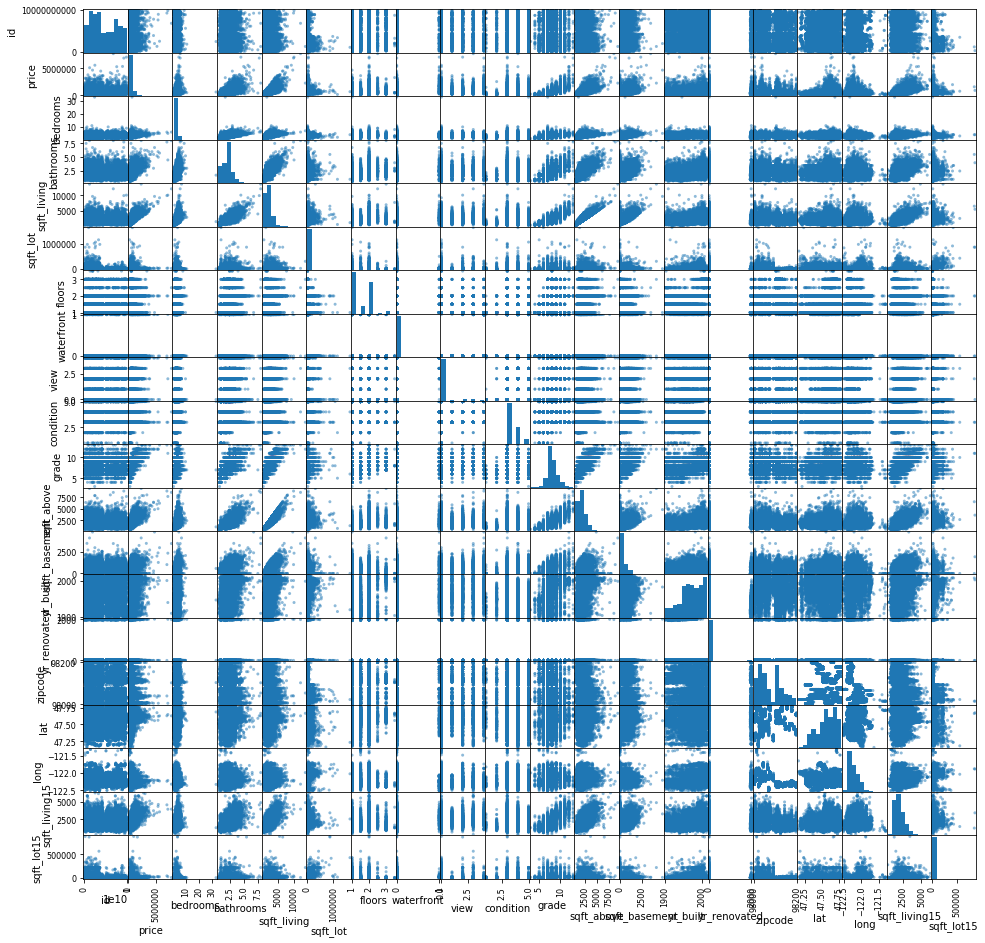

In [20]:
# Here's a high level view of our data:
pd.plotting.scatter_matrix(df,figsize =[16, 16]);
plt.show()

In [21]:
df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702328
grade            0.667738
sqft_above       0.605143
sqft_living15    0.586415
bathrooms        0.525889
view             0.394885
sqft_basement    0.325008
bedrooms         0.309204
lat              0.306507
waterfront       0.265969
floors           0.256355
yr_renovated     0.116719
sqft_lot         0.087937
sqft_lot15       0.083192
yr_built         0.054459
condition        0.035290
long             0.022101
id              -0.015796
zipcode         -0.053166
Name: price, dtype: float64

Some columns (sqft_living) look highly correlated with price. Some (zipcode) not so much. 

In [22]:
# Price is the target variable, so let's remove that from the dataset to start our analysis
# ID is also unhelpful in a correlation, so we'll remove that too
# Date will also be dropped, since that's a string

data_pred = df.iloc[:,3:21]
data_pred.head(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [23]:
import statsmodels.api as sm
y = df['price']
x = data_pred
X = sm.add_constant(x)

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
linreg = sm.OLS(y, X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2904.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:54:24   Log-Likelihood:            -2.8823e+05
No. Observations:               21143   AIC:                         5.765e+05
Df Residuals:                   21125   BIC:                         5.766e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.973e+06   2.96e+06      2.352      0.019    1.16e+06    1.28e+07
bedrooms      -3.597e+04   1925.495    -18.679      0.000   -3.97e+04   -3.22e+04
bathrooms      4.126e+04   3304.562     12.485      0.000    3.48e+04    4.77e+04
sqft_living     110.6087      2.303     48.023      0.000     106.094     115.123
sqft_lot          0.1155      0.049      2.360      0.018       0.020       0.211
floors         7216.2119   3649.471      1.977      0.048      62.970    1.44e+04
waterfront     6.256e+05   1.84e+04     34.001      0.000    5.89e+05    6.62e+05
view           5.391e+04   2148.247     25.095      0.000    4.97e+04    5.81e+04
condition      2.698e+04   2374.393     11.363      0.000    2.23e+04    3.16e+04
grade          9.664e+04   2185.019     44.231      0.000    9.24e+04    1.01e+05
sqft_above       70.4917      2.279     30.936      0.000      66.025      74.958
sqft_basement    40.1126      2.681     14.963      0.000      34.858      45.367
yr_built      -2641.3697     72.897    -36.234      0.000   -2784.253   -2498.487
yr_renovated     23.6681      4.036      5.865      0.000      15.758      31.579
zipcode        -587.5225     33.386    -17.598      0.000    -652.961    -522.084
lat            6.002e+05   1.09e+04     55.247      0.000    5.79e+05    6.22e+05
long          -2.178e+05   1.33e+04    -16.346      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.9805      3.486      6.305      0.000      15.148      28.813
sqft_lot15       -0.3786      0.075     -5.062      0.000      -0.525      -0.232
==============================================================================
Omnibus:                    17945.209   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1803095.931
Skew:                           3.557   Prob(JB):                         0.00
Kurtosis:                      47.678   Cond. No.                     4.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

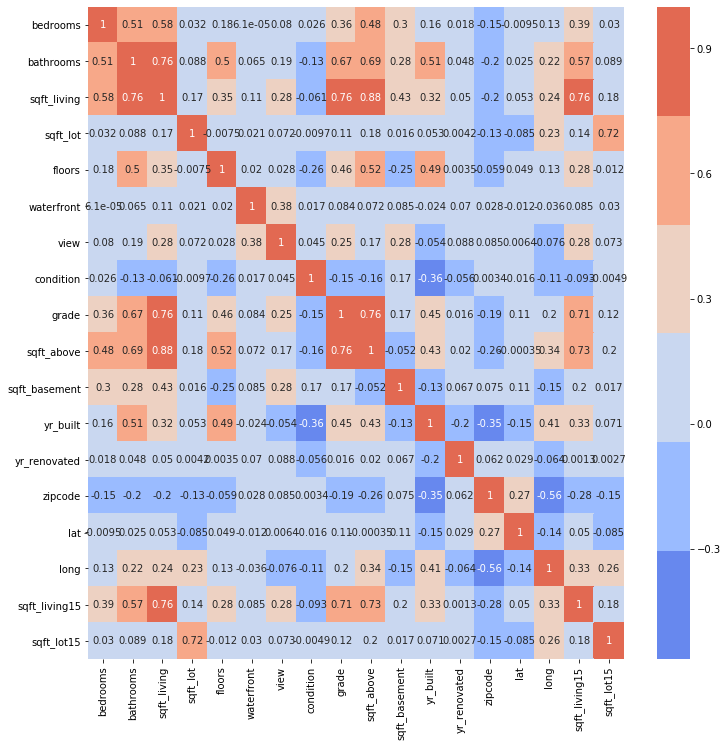

In [25]:
# Let's look for covariance among the predictor variables
corr = data_pred.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap=sns.color_palette('coolwarm'))
plt.show()

In looking for covariance, we're looking how the relationship between variables could impact the outcome
For example, measuring the sqft and sqin on a bathroom would be double-counting the size of the same room

Based on the above, let's remove zipcode
* other variables are related (sqft_above and sqft_living) but they also highly impact the y
* long has little correlation impact, so we'll remove that too

In [26]:
df = df.drop(['zipcode','long'], axis=1)
data_pred.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


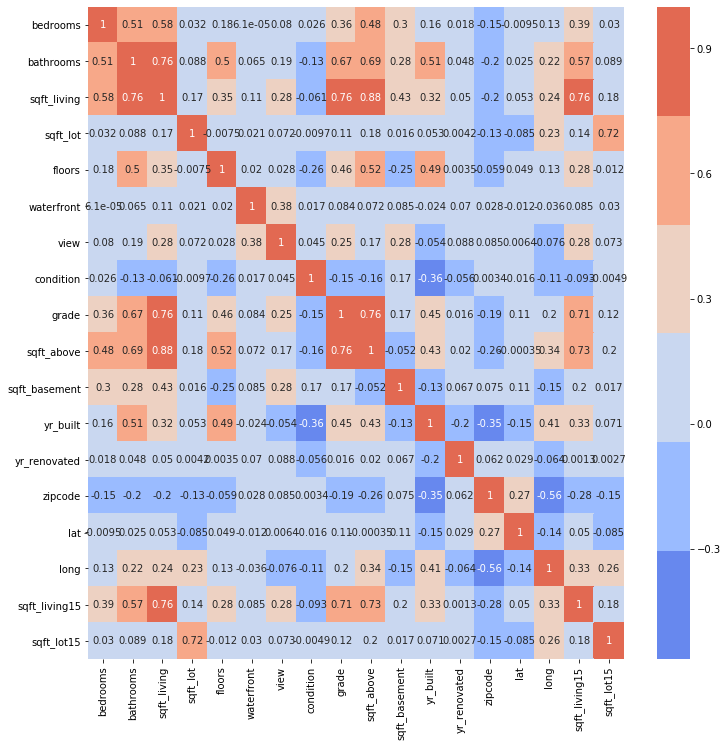

In [27]:
# Let's check again for covariance:
corr = data_pred.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap=sns.color_palette('coolwarm'))
plt.show()

In [28]:
# run that model one more time...
y = df['price']
x = data_pred
X = sm.add_constant(x)
linreg = sm.OLS(y, X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2904.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:54:38   Log-Likelihood:            -2.8823e+05
No. Observations:               21143   AIC:                         5.765e+05
Df Residuals:                   21125   BIC:                         5.766e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.973e+06   2.96e+06      2.352      0.019    1.16e+06    1.28e+07
bedrooms      -3.597e+04   1925.495    -18.679      0.000   -3.97e+04   -3.22e+04
bathrooms      4.126e+04   3304.562     12.485      0.000    3.48e+04    4.77e+04
sqft_living     110.6087      2.303     48.023      0.000     106.094     115.123
sqft_lot          0.1155      0.049      2.360      0.018       0.020       0.211
floors         7216.2119   3649.471      1.977      0.048      62.970    1.44e+04
waterfront     6.256e+05   1.84e+04     34.001      0.000    5.89e+05    6.62e+05
view           5.391e+04   2148.247     25.095      0.000    4.97e+04    5.81e+04
condition      2.698e+04   2374.393     11.363      0.000    2.23e+04    3.16e+04
grade          9.664e+04   2185.019     44.231      0.000    9.24e+04    1.01e+05
sqft_above       70.4917      2.279     30.936      0.000      66.025      74.958
sqft_basement    40.1126      2.681     14.963      0.000      34.858      45.367
yr_built      -2641.3697     72.897    -36.234      0.000   -2784.253   -2498.487
yr_renovated     23.6681      4.036      5.865      0.000      15.758      31.579
zipcode        -587.5225     33.386    -17.598      0.000    -652.961    -522.084
lat            6.002e+05   1.09e+04     55.247      0.000    5.79e+05    6.22e+05
long          -2.178e+05   1.33e+04    -16.346      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.9805      3.486      6.305      0.000      15.148      28.813
sqft_lot15       -0.3786      0.075     -5.062      0.000      -0.525      -0.232
==============================================================================
Omnibus:                    17945.209   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1803095.931
Skew:                           3.557   Prob(JB):                         0.00
Kurtosis:                      47.678   Cond. No.                     4.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,47.5112,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,47.7210,1690,7639


In [30]:
# we have a lot of zero values in yr_renovated
# for now, let's make this binary. 
# this is a big assumption - a renovation in the 1950s is not the same as the 1990s
# yr_renovated doesn't seem to have a large coeffiencient, so let's see how this impacts it

df['reno_binary'] = np.where(df['yr_renovated'] > 1, 1,0)
df = df.drop(['yr_renovated'], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,sqft_living15,sqft_lot15,reno_binary
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,47.5112,1340,5650,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,47.7210,1690,7639,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,47.7379,2720,8062,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,47.5208,1360,5000,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,47.6168,1800,7503,0


In [31]:
y = df['price']
x = data_pred
X = sm.add_constant(x)

linreg = sm.OLS(y, X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2904.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:54:45   Log-Likelihood:            -2.8823e+05
No. Observations:               21143   AIC:                         5.765e+05
Df Residuals:                   21125   BIC:                         5.766e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.973e+06   2.96e+06      2.352      0.019    1.16e+06    1.28e+07
bedrooms      -3.597e+04   1925.495    -18.679      0.000   -3.97e+04   -3.22e+04
bathrooms      4.126e+04   3304.562     12.485      0.000    3.48e+04    4.77e+04
sqft_living     110.6087      2.303     48.023      0.000     106.094     115.123
sqft_lot          0.1155      0.049      2.360      0.018       0.020       0.211
floors         7216.2119   3649.471      1.977      0.048      62.970    1.44e+04
waterfront     6.256e+05   1.84e+04     34.001      0.000    5.89e+05    6.62e+05
view           5.391e+04   2148.247     25.095      0.000    4.97e+04    5.81e+04
condition      2.698e+04   2374.393     11.363      0.000    2.23e+04    3.16e+04
grade          9.664e+04   2185.019     44.231      0.000    9.24e+04    1.01e+05
sqft_above       70.4917      2.279     30.936      0.000      66.025      74.958
sqft_basement    40.1126      2.681     14.963      0.000      34.858      45.367
yr_built      -2641.3697     72.897    -36.234      0.000   -2784.253   -2498.487
yr_renovated     23.6681      4.036      5.865      0.000      15.758      31.579
zipcode        -587.5225     33.386    -17.598      0.000    -652.961    -522.084
lat            6.002e+05   1.09e+04     55.247      0.000    5.79e+05    6.22e+05
long          -2.178e+05   1.33e+04    -16.346      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.9805      3.486      6.305      0.000      15.148      28.813
sqft_lot15       -0.3786      0.075     -5.062      0.000      -0.525      -0.232
==============================================================================
Omnibus:                    17945.209   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1803095.931
Skew:                           3.557   Prob(JB):                         0.00
Kurtosis:                      47.678   Cond. No.                     4.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2c1c26a0>,
      dtype=object)

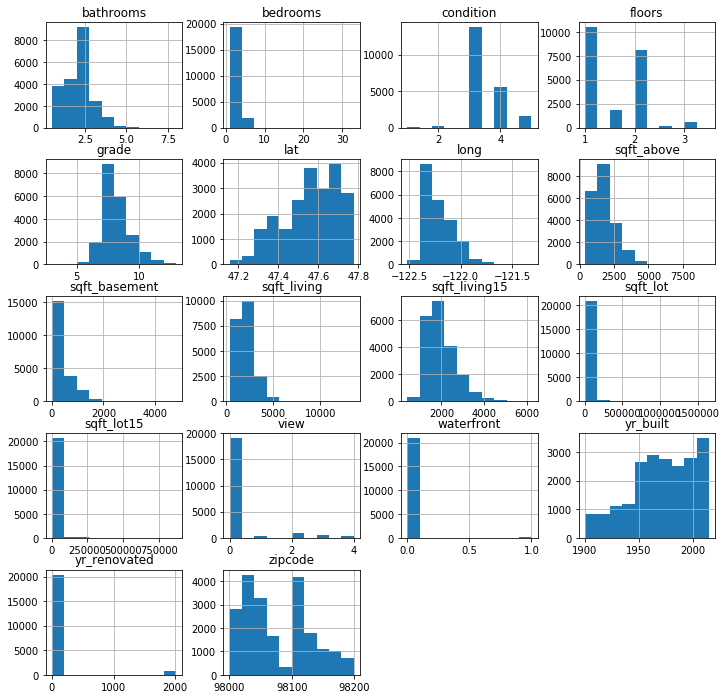

In [32]:
# We have some categorical variables - let's decide what to do with those
data_pred.hist(figsize=(12,12))
# categorical: waterfront, reno_binary
# note: values for bedrooms, floors, etc. could also be considered categorial, in that they're non-infinite
# since the plots above made fairly neat scatter formations, we'll consider them continuous

Next up, we'll investigate which columns should be log transformed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f1f5eb8>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fbb02e8>,
      dtype=object)

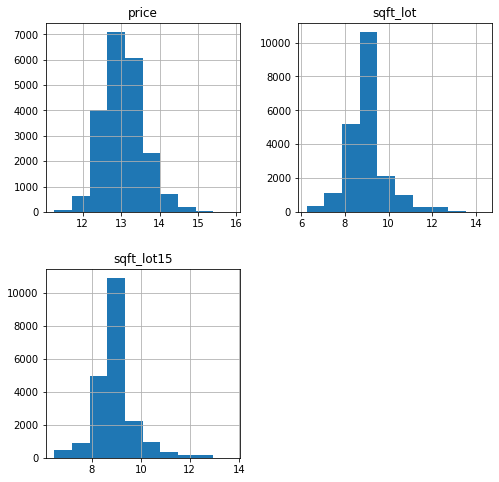

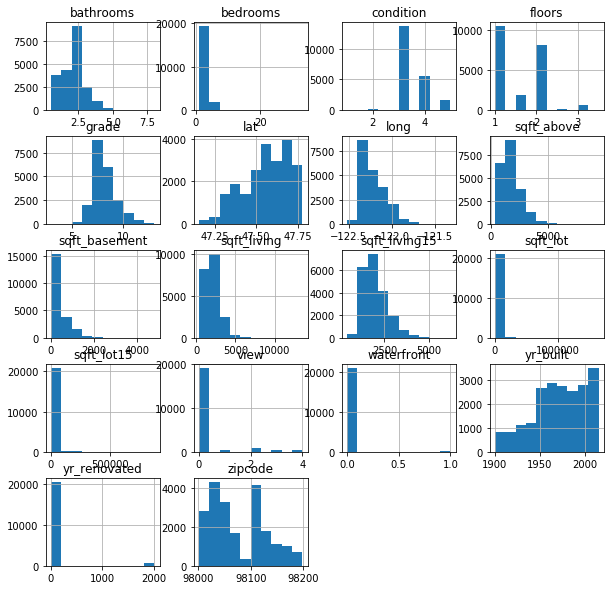

In [34]:
# Based on the above, candidates for log transformations appear to be:
# bedrooms, bathrooms, yr_built, floors, lat, sqft_above, sqft_living, sqft_living15, sqft_lot15, view, condition
# sqft_basement and view are continuous, but contain a lot of zeroes (which can't be log transformed)
# these are (mostly) continuous variables - we'll deal with categorical ones later
# let's look at the histogram of log vs. original values

data_log = pd.DataFrame([])

data_log['price'] = np.log(df['price'])
data_log['sqft_lot'] = np.log(df['sqft_lot'])
data_log['sqft_lot15'] = np.log(df['sqft_lot15'])


display(data_log.hist(figsize=(8,8)))
display(data_pred.hist(figsize=(10,10)))
# well, yr_built looks the exact same 
# let's use the log of the rest of the set above

In [35]:
df['price'] = data_log['price']
df['sqft_lot'] = data_log['sqft_lot']
df['sqft_lot15'] = data_log['sqft_lot15']

In [36]:
y = df['price']
x = data_pred
X = sm.add_constant(x)

linreg = sm.OLS(y, X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     4166.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:55:01   Log-Likelihood:                -894.33
No. Observations:               21143   AIC:                             1825.
Df Residuals:                   21125   BIC:                             1968.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.1809      3.714     -1.126      0.260     -11.461       3.099
bedrooms         -0.0128      0.002     -5.306      0.000      -0.018      -0.008
bathrooms         0.0690      0.004     16.659      0.000       0.061       0.077
sqft_living    9.624e-05   2.89e-06     33.350      0.000    9.06e-05       0.000
sqft_lot       4.785e-07   6.13e-08      7.807      0.000    3.58e-07    5.99e-07
floors            0.0755      0.005     16.524      0.000       0.067       0.085
waterfront        0.3721      0.023     16.143      0.000       0.327       0.417
view              0.0624      0.003     23.173      0.000       0.057       0.068
condition         0.0626      0.003     21.053      0.000       0.057       0.068
grade             0.1596      0.003     58.320      0.000       0.154       0.165
sqft_above     4.011e-05   2.85e-06     14.050      0.000    3.45e-05    4.57e-05
sqft_basement  5.613e-05   3.36e-06     16.712      0.000    4.95e-05    6.27e-05
yr_built         -0.0034   9.13e-05    -37.734      0.000      -0.004      -0.003
yr_renovated   4.081e-05   5.06e-06      8.071      0.000    3.09e-05    5.07e-05
zipcode          -0.0007   4.18e-05    -15.609      0.000      -0.001      -0.001
lat               1.3976      0.014    102.678      0.000       1.371       1.424
long             -0.1589      0.017     -9.523      0.000      -0.192      -0.126
sqft_living15  9.778e-05   4.37e-06     22.390      0.000    8.92e-05       0.000
sqft_lot15    -2.789e-07   9.37e-08     -2.976      0.003   -4.63e-07   -9.52e-08
==============================================================================
Omnibus:                      372.429   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.819
Skew:                          -0.023   Prob(JB):                    8.35e-167
Kurtosis:                       3.931   Cond. No.                     4.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
# and check each variable's contribution to the model again: 
df.corr()['price'].sort_values(ascending=False)

price            1.000000
grade            0.703507
sqft_living      0.695423
sqft_living15    0.620330
sqft_above       0.601456
bathrooms        0.551095
lat              0.449279
view             0.344940
bedrooms         0.343088
sqft_basement    0.317577
floors           0.310110
waterfront       0.170654
sqft_lot         0.138365
sqft_lot15       0.124307
reno_binary      0.106782
yr_built         0.080771
condition        0.037628
id              -0.003956
Name: price, dtype: float64

In [38]:
# id isn't adding anything here - let's drop it!
df = df.drop(['id'], axis=1)

In [39]:
y = df['price']
x = data_pred
X = sm.add_constant(x)

linreg = sm.OLS(y, X).fit()
display(linreg.summary())
display(df.corr()['price'].sort_values(ascending=False))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     4166.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:55:08   Log-Likelihood:                -894.33
No. Observations:               21143   AIC:                             1825.
Df Residuals:                   21125   BIC:                             1968.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.1809      3.714     -1.126      0.260     -11.461       3.099
bedrooms         -0.0128      0.002     -5.306      0.000      -0.018      -0.008
bathrooms         0.0690      0.004     16.659      0.000       0.061       0.077
sqft_living    9.624e-05   2.89e-06     33.350      0.000    9.06e-05       0.000
sqft_lot       4.785e-07   6.13e-08      7.807      0.000    3.58e-07    5.99e-07
floors            0.0755      0.005     16.524      0.000       0.067       0.085
waterfront        0.3721      0.023     16.143      0.000       0.327       0.417
view              0.0624      0.003     23.173      0.000       0.057       0.068
condition         0.0626      0.003     21.053      0.000       0.057       0.068
grade             0.1596      0.003     58.320      0.000       0.154       0.165
sqft_above     4.011e-05   2.85e-06     14.050      0.000    3.45e-05    4.57e-05
sqft_basement  5.613e-05   3.36e-06     16.712      0.000    4.95e-05    6.27e-05
yr_built         -0.0034   9.13e-05    -37.734      0.000      -0.004      -0.003
yr_renovated   4.081e-05   5.06e-06      8.071      0.000    3.09e-05    5.07e-05
zipcode          -0.0007   4.18e-05    -15.609      0.000      -0.001      -0.001
lat               1.3976      0.014    102.678      0.000       1.371       1.424
long             -0.1589      0.017     -9.523      0.000      -0.192      -0.126
sqft_living15  9.778e-05   4.37e-06     22.390      0.000    8.92e-05       0.000
sqft_lot15    -2.789e-07   9.37e-08     -2.976      0.003   -4.63e-07   -9.52e-08
==============================================================================
Omnibus:                      372.429   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.819
Skew:                          -0.023   Prob(JB):                    8.35e-167
Kurtosis:                       3.931   Cond. No.                     4.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

price            1.000000
grade            0.703507
sqft_living      0.695423
sqft_living15    0.620330
sqft_above       0.601456
bathrooms        0.551095
lat              0.449279
view             0.344940
bedrooms         0.343088
sqft_basement    0.317577
floors           0.310110
waterfront       0.170654
sqft_lot         0.138365
sqft_lot15       0.124307
reno_binary      0.106782
yr_built         0.080771
condition        0.037628
Name: price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d3826a0>,
      dtype=object)

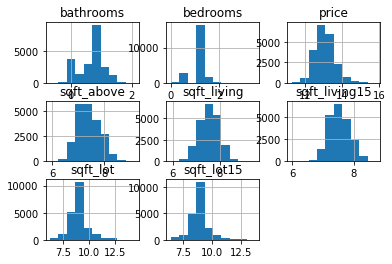

In [40]:
# I think there's some more work to be done - some variables still looked skewed above
# let's log transform: bedrooms, bathrooms, sqft_above, sqft_living, sqft_living15

data_log['bedrooms'] = np.log(df['bedrooms'])
data_log['bathrooms'] = np.log(df['bathrooms'])
data_log['sqft_above'] = np.log(df['sqft_above'])
data_log['sqft_living'] = np.log(df['sqft_living'])
data_log['sqft_living15'] = np.log(df['sqft_living15'])
data_log.hist()
# looks much better and much less skewed!

In [41]:
df['bedrooms'] = data_log['bedrooms']
df['bathrooms'] = data_log['bathrooms']
df['sqft_above'] = data_log['sqft_above']
df['sqft_living'] = data_log['sqft_living']
df['sqft_living15'] = data_log['sqft_living15']

In [42]:
y = df['price']
x = data_pred
X = sm.add_constant(x)

linreg = sm.OLS(y, X).fit()
display(linreg.summary())
display(df.corr()['price'].sort_values(ascending=False))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     4166.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:55:18   Log-Likelihood:                -894.33
No. Observations:               21143   AIC:                             1825.
Df Residuals:                   21125   BIC:                             1968.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.1809      3.714     -1.126      0.260     -11.461       3.099
bedrooms         -0.0128      0.002     -5.306      0.000      -0.018      -0.008
bathrooms         0.0690      0.004     16.659      0.000       0.061       0.077
sqft_living    9.624e-05   2.89e-06     33.350      0.000    9.06e-05       0.000
sqft_lot       4.785e-07   6.13e-08      7.807      0.000    3.58e-07    5.99e-07
floors            0.0755      0.005     16.524      0.000       0.067       0.085
waterfront        0.3721      0.023     16.143      0.000       0.327       0.417
view              0.0624      0.003     23.173      0.000       0.057       0.068
condition         0.0626      0.003     21.053      0.000       0.057       0.068
grade             0.1596      0.003     58.320      0.000       0.154       0.165
sqft_above     4.011e-05   2.85e-06     14.050      0.000    3.45e-05    4.57e-05
sqft_basement  5.613e-05   3.36e-06     16.712      0.000    4.95e-05    6.27e-05
yr_built         -0.0034   9.13e-05    -37.734      0.000      -0.004      -0.003
yr_renovated   4.081e-05   5.06e-06      8.071      0.000    3.09e-05    5.07e-05
zipcode          -0.0007   4.18e-05    -15.609      0.000      -0.001      -0.001
lat               1.3976      0.014    102.678      0.000       1.371       1.424
long             -0.1589      0.017     -9.523      0.000      -0.192      -0.126
sqft_living15  9.778e-05   4.37e-06     22.390      0.000    8.92e-05       0.000
sqft_lot15    -2.789e-07   9.37e-08     -2.976      0.003   -4.63e-07   -9.52e-08
==============================================================================
Omnibus:                      372.429   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.819
Skew:                          -0.023   Prob(JB):                    8.35e-167
Kurtosis:                       3.931   Cond. No.                     4.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

price            1.000000
grade            0.703507
sqft_living      0.674654
sqft_living15    0.607955
sqft_above       0.585713
bathrooms        0.519778
lat              0.449279
view             0.344940
bedrooms         0.342404
sqft_basement    0.317577
floors           0.310110
waterfront       0.170654
sqft_lot         0.138365
sqft_lot15       0.124307
reno_binary      0.106782
yr_built         0.080771
condition        0.037628
Name: price, dtype: float64

In [ ]:
# we also need to check that all p values < .05
# the highest value is .0001, so we're good there

In [43]:
# next, let's standardize our variables

scaled_grade = (df.grade-np.mean(df.grade))/np.sqrt(np.var(df.grade))
scaled_sqft_living = (df.sqft_living-np.mean(df.sqft_living))/np.sqrt(np.var(df.sqft_living))
scaled_sqft_living15 = (df.sqft_living15-np.mean(df.sqft_living15))/np.sqrt(np.var(df.sqft_living15))
scaled_sqft_above = (df.sqft_above-np.mean(df.sqft_above))/np.sqrt(np.var(df.sqft_above))
scaled_bathrooms = (df.bathrooms-np.mean(df.bathrooms))/np.sqrt(np.var(df.bathrooms))
scaled_lat = (df.lat-np.mean(df.lat))/np.sqrt(np.var(df.lat))
scaled_view = (df.view-np.mean(df.view))/np.sqrt(np.var(df.view))
scaled_bedrooms = (df.bedrooms-np.mean(df.bedrooms))/np.sqrt(np.var(df.bedrooms))
scaled_sqft_basement = (df.sqft_basement-np.mean(df.sqft_basement))/np.sqrt(np.var(df.sqft_basement))
scaled_floors = (df.floors-np.mean(df.floors))/np.sqrt(np.var(df.floors))
scaled_waterfront = (df.waterfront-np.mean(df.waterfront))/np.sqrt(np.var(df.waterfront))
scaled_sqft_lot = (df.sqft_lot-np.mean(df.sqft_lot))/np.sqrt(np.var(df.sqft_lot))
scaled_reno_binary = (df.reno_binary-np.mean(df.reno_binary))/np.sqrt(np.var(df.reno_binary))
scaled_yr_built = (df.yr_built-np.mean(df.yr_built))/np.sqrt(np.var(df.yr_built))
scaled_condition = (df.condition-np.mean(df.condition))/np.sqrt(np.var(df.condition))

# Wow, that was tedious!
# Note to self: just write a function next time
# I also plotted the histogram as I went along, for a visual check

In [44]:
# Now that we've standardized our values, it's time to incorporate back into the main dataframe
df['grade'] = scaled_grade
df['sqft_living'] = scaled_sqft_living
df['sqft_living15'] = scaled_sqft_living15
df['sqft_above'] = scaled_sqft_above
df['bathrooms'] = scaled_bathrooms
df['lat'] = scaled_lat
df['view'] = scaled_view
df['bedrooms'] = scaled_bedrooms
df['sqft_basement'] = scaled_sqft_basement
df['floors'] = scaled_floors
df['waterfront'] = scaled_waterfront
df['sqft_lot'] = scaled_sqft_lot
df['reno_binary'] = scaled_reno_binary
df['yr_built'] = scaled_yr_built
df['condition'] = scaled_condition
data_pred.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [45]:
y = df['price']
x = data_pred
X = sm.add_constant(x)

linreg = sm.OLS(y, X).fit()
display(linreg.summary())
display(df.corr()['price'].sort_values(ascending=False))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     4166.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:55:26   Log-Likelihood:                -894.33
No. Observations:               21143   AIC:                             1825.
Df Residuals:                   21125   BIC:                             1968.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.1809      3.714     -1.126      0.260     -11.461       3.099
bedrooms         -0.0128      0.002     -5.306      0.000      -0.018      -0.008
bathrooms         0.0690      0.004     16.659      0.000       0.061       0.077
sqft_living    9.624e-05   2.89e-06     33.350      0.000    9.06e-05       0.000
sqft_lot       4.785e-07   6.13e-08      7.807      0.000    3.58e-07    5.99e-07
floors            0.0755      0.005     16.524      0.000       0.067       0.085
waterfront        0.3721      0.023     16.143      0.000       0.327       0.417
view              0.0624      0.003     23.173      0.000       0.057       0.068
condition         0.0626      0.003     21.053      0.000       0.057       0.068
grade             0.1596      0.003     58.320      0.000       0.154       0.165
sqft_above     4.011e-05   2.85e-06     14.050      0.000    3.45e-05    4.57e-05
sqft_basement  5.613e-05   3.36e-06     16.712      0.000    4.95e-05    6.27e-05
yr_built         -0.0034   9.13e-05    -37.734      0.000      -0.004      -0.003
yr_renovated   4.081e-05   5.06e-06      8.071      0.000    3.09e-05    5.07e-05
zipcode          -0.0007   4.18e-05    -15.609      0.000      -0.001      -0.001
lat               1.3976      0.014    102.678      0.000       1.371       1.424
long             -0.1589      0.017     -9.523      0.000      -0.192      -0.126
sqft_living15  9.778e-05   4.37e-06     22.390      0.000    8.92e-05       0.000
sqft_lot15    -2.789e-07   9.37e-08     -2.976      0.003   -4.63e-07   -9.52e-08
==============================================================================
Omnibus:                      372.429   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.819
Skew:                          -0.023   Prob(JB):                    8.35e-167
Kurtosis:                       3.931   Cond. No.                     4.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

price            1.000000
grade            0.703507
sqft_living      0.674654
sqft_living15    0.607955
sqft_above       0.585713
bathrooms        0.519778
lat              0.449279
view             0.344940
bedrooms         0.342404
sqft_basement    0.317577
floors           0.310110
waterfront       0.170654
sqft_lot         0.138365
sqft_lot15       0.124307
reno_binary      0.106782
yr_built         0.080771
condition        0.037628
Name: price, dtype: float64

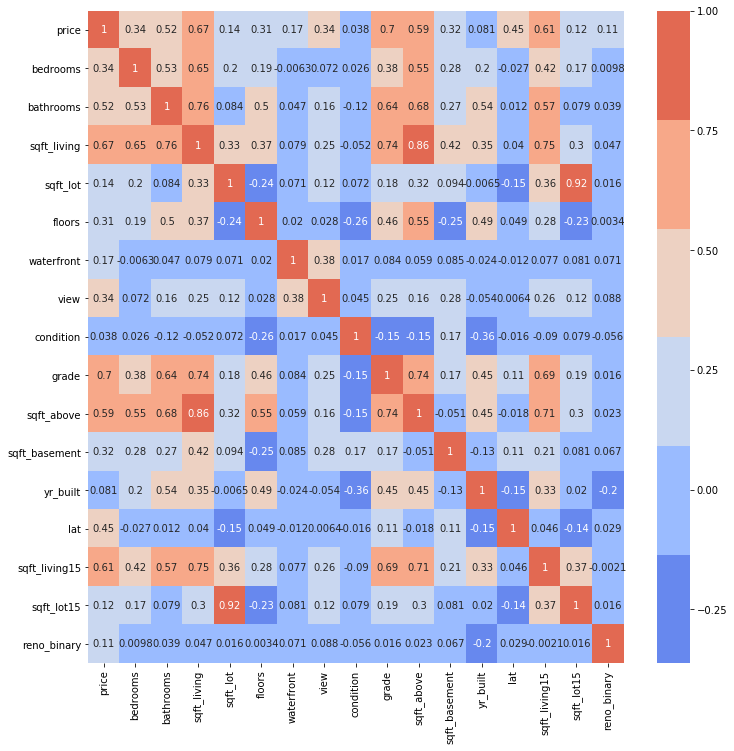

In [46]:
corr = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap=sns.color_palette('coolwarm'))
plt.show()

In [ ]:
# our categorical variables left are both binary (waterfront, reno_binary)
# there's no need to use dummies here, as that just...makes them binary

We've ended up with a model that can predict with 77% accuracy the sales price of a house, based on the above factors. Pretty cool!

# 3. Wrapping Up

Which variable has the biggest impact on the sales price of a house?

In [57]:
model = sm.OLS(y, X)
results = model.fit()
display(linreg.params)

coef = abs(linreg.params)
sorted_coef = sorted(coef)
sorted_coef
# we're looking for the params with the largest absolute value
# based on this, we'll dive into the impact of: lat, waterfront, grade

const           -4.180875e+00
bedrooms        -1.279899e-02
bathrooms        6.896836e-02
sqft_living      9.623539e-05
sqft_lot         4.785445e-07
floors           7.554996e-02
waterfront       3.721034e-01
view             6.236849e-02
condition        6.262629e-02
grade            1.596499e-01
sqft_above       4.010875e-05
sqft_basement    5.612930e-05
yr_built        -3.446173e-03
yr_renovated     4.080969e-05
zipcode         -6.528714e-04
lat              1.397623e+00
long            -1.589401e-01
sqft_living15    9.778415e-05
sqft_lot15      -2.788644e-07
dtype: float64

[2.78864449598615e-07,
 4.785444749732158e-07,
 4.0108748654747106e-05,
 4.080968873328844e-05,
 5.6129301423623424e-05,
 9.623539191916868e-05,
 9.778415192186076e-05,
 0.0006528714250608673,
 0.003446173412758817,
 0.012798988341133105,
 0.06236848719512822,
 0.06262629008303297,
 0.06896836310051202,
 0.07554996272552317,
 0.15894009784564544,
 0.15964986770838888,
 0.3721033555646166,
 1.3976232872857144,
 4.180874854585227]

Here's what this means:
* Our intercept is ###
* Coefficient 1 has an impact of ###
* Coefficient 2 has an impact of ###
* Coefficient 3 has an impact of ###

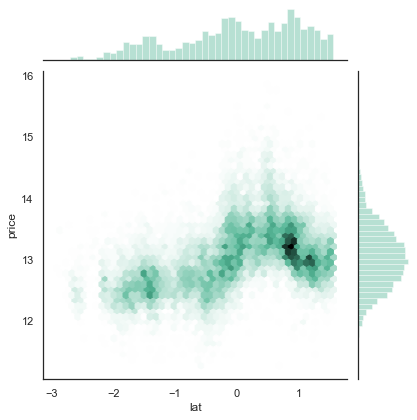

In [70]:
# examining the impact of lat
lat_data = df[['lat', 'price']]
sns.set(style="white")

x = lat_data['lat']
y = lat_data['price']

sns.jointplot(x, y, kind="hex", color="#4CB391")
# in our adjusted dataset, there are a high number of high sales prices between lat 0 and 1
# this also suggestes that lower lats (farther south geographically) have lower selling prices

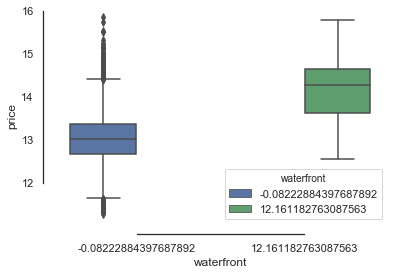

In [72]:
# examining the impact of waterfront
waterfront_data = df[['waterfront', 'price']]
sns.boxplot(x='waterfront', y='price',
            hue='waterfront', palette=['b', 'g'],
            data=waterfront_data)
sns.despine(offset=10, trim=True)
# this shows a significant difference in the quartiles between waterfront and not
# in fact, the first quartile of waterfront homes is higher than the third quartile of not!
# there are also significant outliters in not - high selling price without being by the water

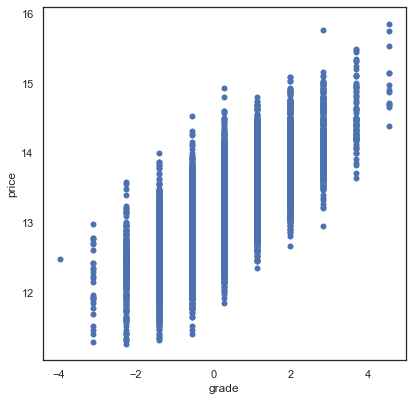

In [82]:
# examining the impact of grade
grade_data = df[['grade', 'price']]
f, ax = plt.subplots(figsize=(6.5, 6.5))
display(sns.scatterplot(x='grade', y='price',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=grade_data, ax=ax))
# again, the higher the grade the (likely) higher the selling price
# there are relatively few houses sold with grade (adjusted) >4; they all sold for more than the houses with grade < -2

# 4. Other Info


Exploratory analysis for the future: 
* How does the time of house sale impact the price?
* Improve heatmap to show sale price
* Look at average (or median) sales price by year (I would expect this to be high for very old homes and then dip in the middle of the range, increase for more recent builds)

Model fit things for the future:
* Check qq plots, heteroscedasticity
* Create different dataframes for each zipcode, compare models
* Split data into test/train sets to confirm model fit

If I did this project again, I'd re-run the last section with non-transformed variables. I know things don't need to be "perfect" but I'd like to get a sense of the real latitude and it's price impact, to use an example. This would have been great to have when building the presentation.